In [1]:
from binance.client import Client
import keys
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from tqdm import tqdm
# import mplfinance as mpf


pd.set_option('display.max_columns', None)

client = Client(keys.api_key, keys.api_secret)

In [2]:
# pip install python-binance

In [3]:
import seaborn as sns

In [4]:
def get_start_end_date():
    now = datetime.now()
    year_ago = now - timedelta(days=1300)


    date_start = year_ago.strftime('%d.%m.%Y')
    date_end = now.strftime('%d.%m.%Y')
    
    return date_start, date_end

In [5]:
date_start, date_end = get_start_end_date()

pair_names = "ETHUSDT"
load_list = client.get_historical_klines(pair_names, Client.KLINE_INTERVAL_1DAY, date_start, date_end)
df_quotes = pd.DataFrame(load_list, columns=['Open time',
 'Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'Close time',
 'Quote asset volume',
 'Number of trades',
 'Taker buy base asset volume',
 'Taker buy quote asset volume',
 'Ignore'])

# info = client.get_exchange_info()

In [5]:
"""
'Quote asset volume' - объем торгов за день котируемого актива. 
'quote asset' - Котируемый актив - Основной актив, к примеру USDT
'base asset' - Базовый актив - что мы оцениваем с помощью котируемого.
'Taker buy base asset volume' - покупатели исполняют ордера на покупку базового актива.
'Taker buy quote asset volume' - покупатели исполняют ордера на покупку котируемого актива.
'Number of trades' - кол-во совершонных сделок.ф
"""

"\n'Quote asset volume' - объем торгов за день котируемого актива. \n'quote asset' - Котируемый актив - Основной актив, к примеру USDT\n'base asset' - Базовый актив - что мы оцениваем с помощью котируемого.\n'Taker buy base asset volume' - покупатели исполняют ордера на покупку базового актива.\n'Taker buy quote asset volume' - покупатели исполняют ордера на покупку котируемого актива.\n'Number of trades' - кол-во совершонных сделок.ф\n"

In [6]:
df_quotes.dtypes

Open time                        int64
Open                            object
High                            object
Low                             object
Close                           object
Volume                          object
Close time                       int64
Quote asset volume              object
Number of trades                 int64
Taker buy base asset volume     object
Taker buy quote asset volume    object
Ignore                          object
dtype: object

In [7]:
def convert_formats(df):
    df = df.copy()    
    df['Open time'] = pd.to_datetime(df['Open time'], unit='ms')
    df['Close time'] = pd.to_datetime(df['Close time'], unit='ms')
    col_new_type = {'Open':float, 
                    'High':float, 
                    'Low':float,
                    'Close':float,
                    'Volume':float,
                    'Quote asset volume':float,
                    'Number of trades':int,
                    'Taker buy base asset volume':float,
                    'Taker buy quote asset volume':float
                   }
    
    df = df.astype(col_new_type)
    
    return df
df_main = convert_formats(df_quotes)
df_main = df_main.set_index('Open time')

In [8]:
# Путь к файлу, в который будет сохранен DataFrame
file_path = 'dataframe.pkl'

# Сохраняем DataFrame в файл формата pickle
df_main.to_pickle(file_path)
print(f'DataFrame успешно сохранен в файл {file_path}')


DataFrame успешно сохранен в файл dataframe.pkl


In [3]:
# Путь к файлу, из которого будут прочитаны данные
file_path = 'dataframe.pkl'

# Читаем DataFrame из файла формата pickle
df_main = pd.read_pickle(file_path)
print(f'DataFrame успешно прочитан из файла {file_path}')
# print(df)


DataFrame успешно прочитан из файла dataframe.pkl


In [4]:
# # Есть такие гипотезы.
# 1) Обем влияет на цену. 
# 2) Кол-во сделок за день влияет на цену. 
# 3) Есть паррены цены + объема по которым можно понять, что произходит разворот. 

# Мне сложно проверить это. Я хотел бы для начала сделать некоторую сетку данных.
# да и вообще мне нужно понять, какие полонки я буду добавлять. (т.к. среднее за прошлую неделю просто предыдущий день. 
# Пока с этим не понянки)

# План по колонкам. 
# Предыдущие все 14 дней по ним средняя цена и разброс. 
# Изменилось, не изменилось я буду смотреть согласно этой метрике.


# Цель 1
# Проверить если аномальный объем (выше 95 перцентиля скользящего среднего бъема что)
# (по хорошему я буду смотреть все метрики в сользящем формате. Ибо в прошлом не понятно было бы, какая из них аномалия. )

# Цель 2
# Проверить что стандартное отклонение от скользящего среднего, так же приводит к потенциальнойму сильному движению. 

In [5]:
df_main_eda = df_main[['Quote asset volume',  
        'Open',
         'High',
         'Low',
         'Close',
         'Volume']]

<Axes: xlabel='Open time'>

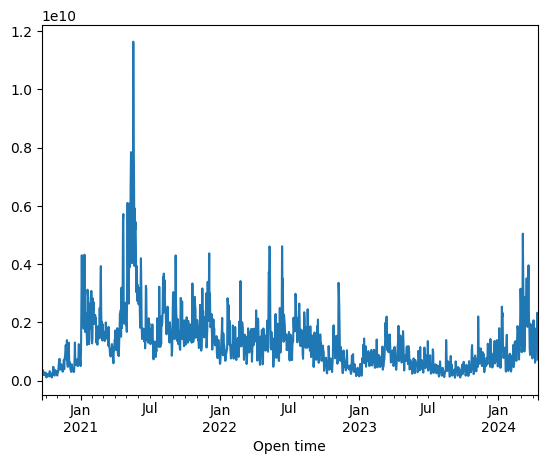

In [6]:
df_main_eda['Quote asset volume'].plot()

<Axes: xlabel='Open time'>

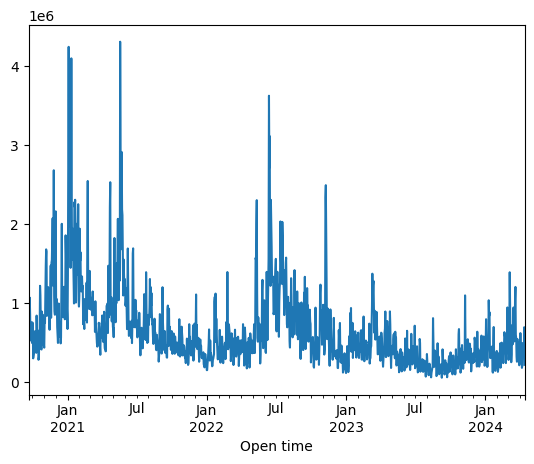

In [7]:
df_main_eda['Volume'].plot()

In [8]:
# Здесь я хотел понять, какой объем брать для рассмотрения. Неожиданно получилось что они в разное время стреляют по разному. 
# Кажтся нужно печатать с ценой.

In [9]:
df_main_eda.head(1)

,Quote asset volume,Open,High,Low,Close,Volume
Open time,,,,,,
2020-09-21,4.521349e+08,371.04,376.8,331.0,340.36,1.283946e+06


# Добавление новых колонок

In [10]:
df_main_eda['mean_price'] = (df_main_eda['Open'] + \
                            df_main_eda['High'] + \
                            df_main_eda['Low'] + \
                            df_main_eda['Close']) / 4

C:\Users\Кирилл\AppData\Local\Temp\ipykernel_20208\160794191.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_main_eda['mean_price'] = (df_main_eda['Open'] + \


In [26]:
# Добавляем новые колонки смещения на 1-7 дней назад
for i in range(1, 31):
    df_main_eda[f'mean_price_shift_{i}'] = df_main_eda['mean_price'].shift(i)



# Применение алгоритмов.

## Тестовый. "Тупой бустинг"

In [27]:
import xgboost as xgb

In [28]:
X_train = df_main_eda.drop(['mean_price'], axis=1)
y_train = df_main_eda['mean_price']

In [29]:
params = {
    "objective": "reg:squarederror",
    "n_estimators":100,
    "max_depth": 4,
    "learning_rate": 0.01,
    "subsample": 0.8,
    "colsample_bytree": 0.9,
    "colsample_bylevel": 0.8,
    "reg_lambda": 0.1,
    "eval_metric": "rmse",
    "random_state": 42,
}
reg = xgb.XGBRegressor(**params)

reg.fit(X_train, 
        y_train, 
#         verbose=False,
#         eval_set= [(X_train, y_train)],
#         early_stopping_rounds=3
        )

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8, colsample_bynode=None, colsample_bytree=0.9,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', feature_types=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [30]:
y_pred = reg.predict(X_train)

mae 126406.1717049066


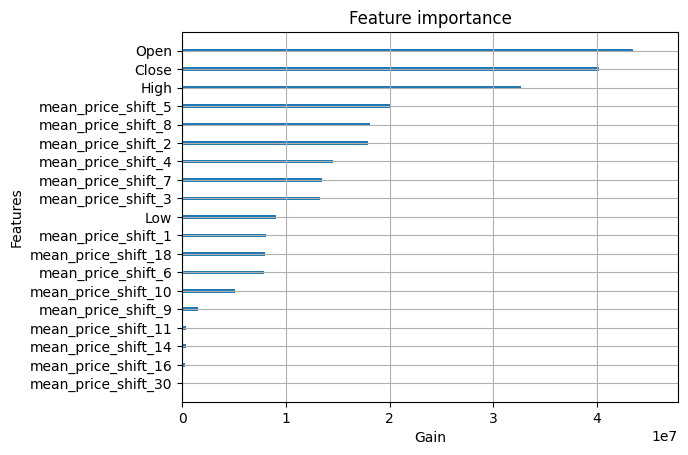

In [31]:
xgb.plot_importance(reg, 
                    importance_type="gain",
                    show_values=False,
                    xlabel="Gain");
print('mae', np.mean((y_train - y_pred)**2))

Если ставить бустинг без ограничения разбиения, то он переобучается и находит закономерность, 
что открытие закрытие верх низ наиболее важные параметры. 
Так же можно достаточно интересно тестировать разные параметры бустинга и понимать какие влияют как на переобучение. 
пока глубина влияла больше всего. 

## Пробую бустинг на нормальных данных.

In [32]:
# Добавление параметров скользящей цены общема и прочего. 
# Цель сделать что-то похожее на ситуации когда модели нужно увидеть паттерн. перед которым случится движение. 
# Сейчас когда я подаю модели не отмаштабированные числа, я не получаю какой-то возможности для идентификации паттерна. 

# Начну я с ситауции когда, по итересующим параметрам я буду искать "одинаковое заданное смещение" 
# Возможно по объему и по самой монете может быть то, что 

names_train_col = []
n_shift = 30 # Вообще 30 дней на первый взгляд кажется довольно много. По этому я позже возможно пересмотрю это. 

cols_name_need_rolling = ['Quote asset volume', 'Volume', 'mean_price']
df_main_eda_roll = df_main_eda.copy()
          
for col in cols_name_need_rolling:
    name_new_col = f'roll_{n_shift}_{col}'
    df_main_eda_roll[name_new_col] = df_main_eda_roll[col].shift(1).rolling(window=n_shift).mean()
    
    print('add:', name_new_col)

add: roll_30_Quote asset volume
add: roll_30_Volume
add: roll_30_mean_price


In [33]:
# Пусть пока таргет будет средене значение. Я думаю лучше две моедли поиска минимума и максимума. Это интереснее. 
df_main_eda_roll['target_scale'] = df_main_eda_roll['mean_price'] / df_main_eda_roll['roll_30_mean_price']

Теперь мне нужно сформировать какие данные влияют на это числа. 
Предположительно я буду брать 30 дней. 
По ним мне интересны.
1) Масштабированыне объема
2) Масштабированыне кол-во сделок
3) Среднее значение по всем сделкам перед этим. 

Позже думаю отойти от средних как от главных признаков. 

In [34]:
for i in range(1, 31):
    name_new_col = f'mean_price_shift_scale_{i}'
    df_main_eda_roll[name_new_col] = df_main_eda_roll['mean_price'].shift(i) /  df_main_eda_roll['roll_30_mean_price']
    names_train_col.append(name_new_col)

In [35]:
for i in range(1, 31):
    name_new_col = f'Quote asset volume_scale_{i}'
    df_main_eda_roll[name_new_col] = df_main_eda_roll['Quote asset volume'].shift(i) / df_main_eda_roll['roll_30_Quote asset volume']
    names_train_col.append(name_new_col)

In [36]:
for i in range(1, 31):
    name_new_col = f'Volume_scale_{i}'
    df_main_eda_roll[name_new_col] = df_main_eda_roll['Volume'].shift(i) / df_main_eda_roll['roll_30_Volume']
    names_train_col.append(name_new_col)

In [37]:
for i in range(1, 31):
    name_new_col = f'std_scale_{i}'
    df_main_eda_roll[name_new_col] = df_main_eda_roll.shift(i)[['Open', 'High', 'Low', 'Close']].std(axis=1) / df_main_eda_roll['mean_price_shift_30']
    names_train_col.append(name_new_col)

C:\Users\Кирилл\AppData\Local\Temp\ipykernel_20208\1282308019.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main_eda_roll[name_new_col] = df_main_eda_roll.shift(i)[['Open', 'High', 'Low', 'Close']].std(axis=1) / df_main_eda_roll['mean_price_shift_30']
C:\Users\Кирилл\AppData\Local\Temp\ipykernel_20208\1282308019.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main_eda_roll[name_new_col] = df_main_eda_roll.shift(i)[['Open', 'High', 'Low', 'Close']].std(axis=1) / df_main_eda_roll['mean_price_shift_30']
C:\Users\Кир

In [38]:
# df_main_eda_roll.to_excel("123.xlsx")

# Аналитика применения алгоритмов.

In [39]:
# import numpy as np

# l = np.array([371.04, 376.80, 331.00, 340.36])
# mean_l = np.mean(l)

# std_ = np.std(l)
# std_scale = std_ / mean_l
# std_scale

In [40]:
df_temp = df_main_eda_roll.copy()
df_temp = df_temp.dropna()


X_train = df_temp[names_train_col].copy()
y_train = df_temp['mean_price'] / df_temp['roll_30_mean_price']

In [41]:
X_train

,mean_price_shift_scale_1,mean_price_shift_scale_2,mean_price_shift_scale_3,mean_price_shift_scale_4,mean_price_shift_scale_5,mean_price_shift_scale_6,mean_price_shift_scale_7,mean_price_shift_scale_8,mean_price_shift_scale_9,mean_price_shift_scale_10,mean_price_shift_scale_11,mean_price_shift_scale_12,mean_price_shift_scale_13,mean_price_shift_scale_14,mean_price_shift_scale_15,mean_price_shift_scale_16,mean_price_shift_scale_17,mean_price_shift_scale_18,mean_price_shift_scale_19,mean_price_shift_scale_20,mean_price_shift_scale_21,mean_price_shift_scale_22,mean_price_shift_scale_23,mean_price_shift_scale_24,mean_price_shift_scale_25,mean_price_shift_scale_26,mean_price_shift_scale_27,mean_price_shift_scale_28,mean_price_shift_scale_29,mean_price_shift_scale_30,Quote asset volume_scale_1,Quote asset volume_scale_2,Quote asset volume_scale_3,Quote asset volume_scale_4,Quote asset volume_scale_5,Quote asset volume_scale_6,Quote asset volume_scale_7,Quote asset volume_scale_8,Quote asset volume_scale_9,Quote asset volume_scale_10,Quote asset volume_scale_11,Quote asset volume_scale_12,Quote asset volume_scale_13,Quote asset volume_scale_14,Quote asset volume_scale_15,Quote asset volume_scale_16,Quote asset volume_scale_17,Quote asset volume_scale_18,Quote asset volume_scale_19,Quote asset volume_scale_20,Quote asset volume_scale_21,Quote asset volume_scale_22,Quote asset volume_scale_23,Quote asset volume_scale_24,Quote asset volume_scale_25,Quote asset volume_scale_26,Quote asset volume_scale_27,Quote asset volume_scale_28,Quote asset volume_scale_29,Quote asset volume_scale_30,Volume_scale_1,Volume_scale_2,Volume_scale_3,Volume_scale_4,Volume_scale_5,Volume_scale_6,Volume_scale_7,Volume_scale_8,Volume_scale_9,Volume_scale_10,Volume_scale_11,Volume_scale_12,Volume_scale_13,Volume_scale_14,Volume_scale_15,Volume_scale_16,Volume_scale_17,Volume_scale_18,Volume_scale_19,Volume_scale_20,Volume_scale_21,Volume_scale_22,Volume_scale_23,Volume_scale_24,Volume_scale_25,Volume_scale_26,Volume_scale_27,Volume_scale_28,Volume_scale_29,Volume_scale_30,std_scale_1,std_scale_2,std_scale_3,std_scale_4,std_scale_5,std_scale_6,std_scale_7,std_scale_8,std_scale_9,std_scale_10,std_scale_11,std_scale_12,std_scale_13,std_scale_14,std_scale_15,std_scale_16,std_scale_17,std_scale_18,std_scale_19,std_scale_20,std_scale_21,std_scale_22,std_scale_23,std_scale_24,std_scale_25,std_scale_26,std_scale_27,std_scale_28,std_scale_29,std_scale_30
Open time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-10-21,1.041519,1.055756,1.040362,1.023266,1.034770,1.051385,1.059967,1.066612,1.060511,1.039650,1.030935,0.998145,0.962203,0.946411,0.966540,0.983496,0.973714,0.966519,0.967195,0.996074,0.998884,0.993383,0.998026,0.990622,0.981774,0.973645,0.933896,0.922308,0.952937,0.989492,1.015149,0.964129,0.533421,0.462870,1.064595,1.052538,0.954926,1.087327,1.415413,0.615150,0.973999,1.028174,0.959491,0.811814,0.979109,0.585688,0.529637,0.465356,1.111842,1.198553,0.784932,0.918461,1.205592,0.893659,0.824788,1.316868,1.592552,1.385486,1.272275,1.996205,0.972764,0.909642,0.509726,0.450018,1.030627,0.999125,0.897516,1.016623,1.330652,0.588279,0.931313,1.025031,0.995590,0.853978,1.008620,0.593672,0.541974,0.478410,1.155971,1.195016,0.786241,0.922076,1.194085,0.897533,0.836566,1.356213,1.688806,1.482689,1.327986,2.023258,0.021737,0.013677,0.017429,0.008790,0.025657,0.014310,0.016667,0.017036,0.036498,0.010986,0.018066,0.029103,0.024825,0.013686,0.025828,0.008888,0.014305,0.008791,0.026017,0.029919,0.012618,0.013694,0.020593,0.017701,0.012657,0.024130,0.053045,0.045418,0.014170,0.063498
2020-10-22,1.062757,1.038889,1.053090,1.037734,1.020682,1.032157,1.048729,1.057290,1.063918,1.057833,1.037025,1.028332,0.995624,0.959773,0.944021,0.964099,0.981013,0.971255,0.964078,0.964753,0.993559,0.996361,0.990874,0.995506,0.988120,0.979295,0.971186,0.931538,0.919979,0.950531,2.079839,1.012117,0.961250,0.531828,0.46148

In [42]:
reg = xgb.XGBRegressor(**params)

reg.fit(X_train, 
        y_train, 
        )

y_pred = reg.predict(X_train)

df_temp['pred'] = y_pred
y_pred = df_temp['pred'] * df_temp['roll_30_mean_price']

# xgb.plot_importance(reg, 
#                     importance_type="gain",
#                     show_values=False,
#                     xlabel="Gain");
# print('mae', np.mean((y_train - y_pred)**2))

In [52]:
# # y_pred, y_train


# plt.figure(figsize=(30, 8))
# sns.lineplot(data=y_train*df_temp['roll_30_mean_price'], 
#              label=f'predict_W1 ',
#              color='g')

# sns.lineplot(data=y_pred, 
#              label=f'predict_W1 ',
#              color='b')



Прогноз по дням

In [66]:
df_temp['pred'] = np.nan
# 
for date in tqdm(df_temp.index.unique(), mininterval=60):
    if date < pd.Timestamp('2023-01-01T00'):
        continue
    
    df_temp_train = df_temp.loc[:date, :]
    df_temp_test = df_temp.loc[date:date, :]
    X_train = df_temp_train[names_train_col].copy()
    y_train = df_temp_train['mean_price'] / df_temp_train['roll_30_mean_price']
    X_test = df_temp_test[names_train_col].copy()
    
    reg = xgb.XGBRegressor(**params)
    reg.fit(X_train, 
            y_train, 
            )

    y_pred = reg.predict(X_test)
    
    
    df_temp.loc[date, 'pred'] = (y_pred * df_temp_test['roll_30_mean_price']).values

#     if date > pd.Timestamp('2023-02-01T00'):
#         break
    
    

100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [05:25<00:00,  3.90it/s]


In [59]:
# print((df_temp[['pred']] - df_temp[['mean_price']]).sum()  )

mean_price    0.0
pred          0.0
dtype: float64


In [60]:
# df_temp[['pred', 'mean_price']].to_excel("123.xlsx")

C:\Users\Кирилл\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Кирилл\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Кирилл\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Кирилл\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWar

<Axes: xlabel='Open time', ylabel='mean_price'>

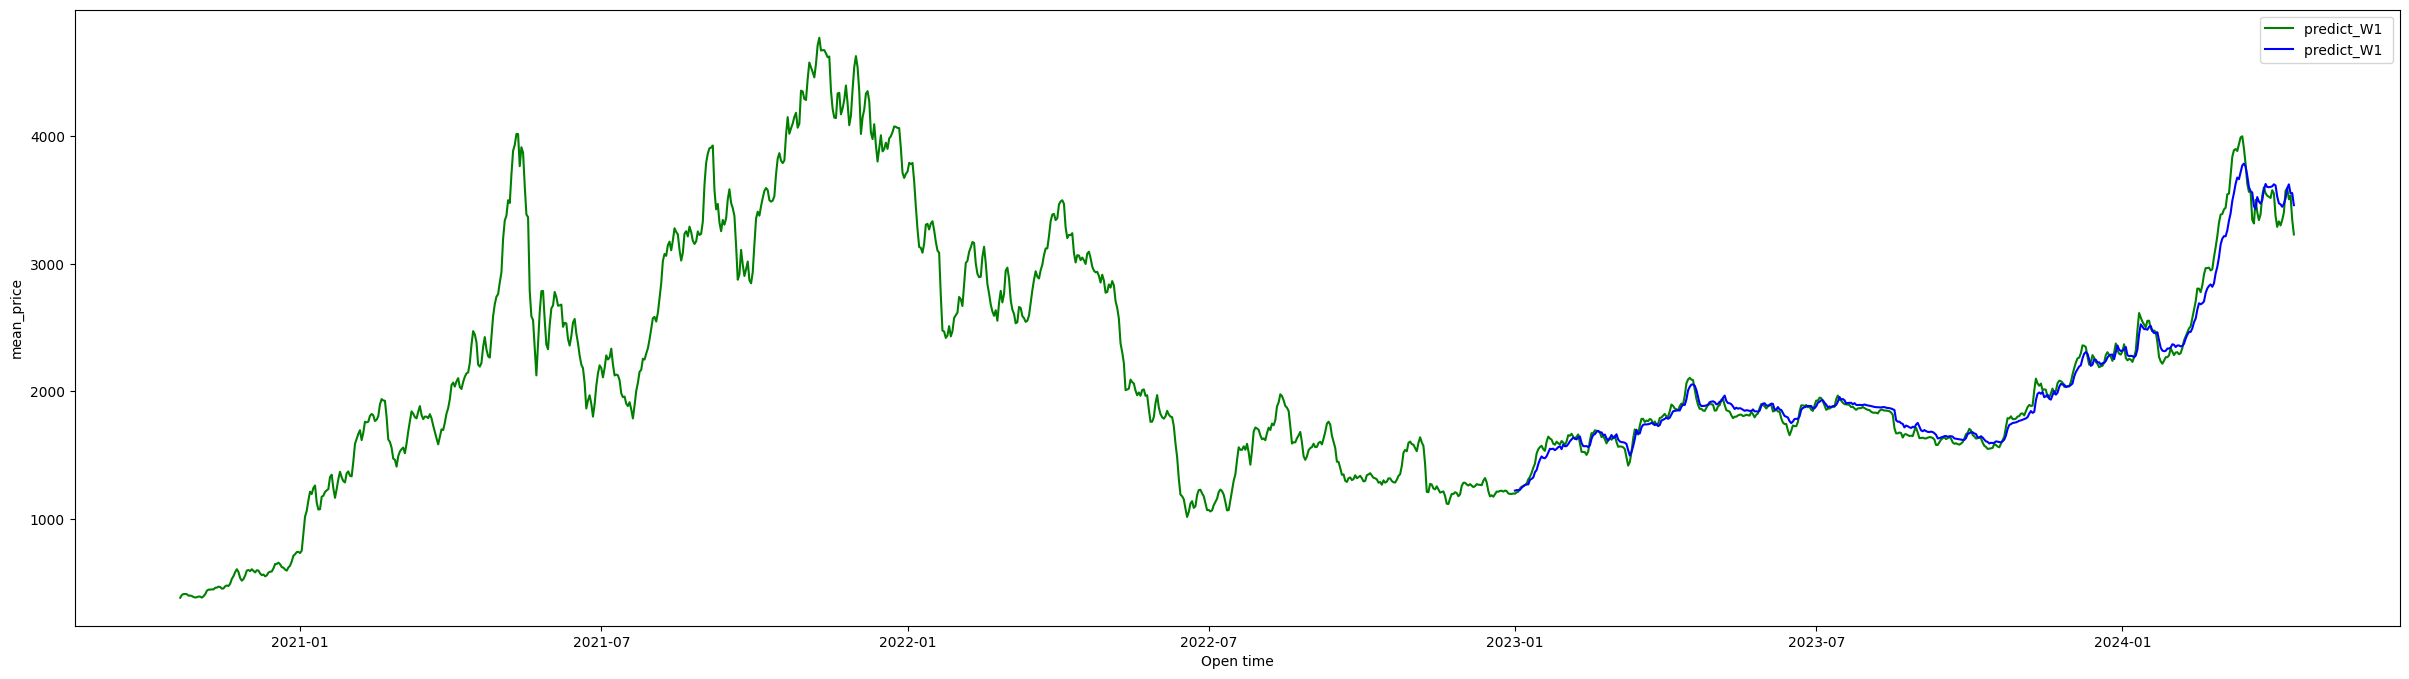

In [67]:
plt.figure(figsize=(30, 8))
sns.lineplot(data=df_temp['mean_price'], 
             label=f'predict_W1 ',
             color='g')

sns.lineplot(data=df_temp['pred'], 
             label=f'predict_W1 ',
             color='b')

In [69]:
df_temp.to_excel('123.xlsx')

# back_testing(with backtrading)

[*********************100%%**********************]  1 of 1 completed


<IPython.core.display.Javascript object>


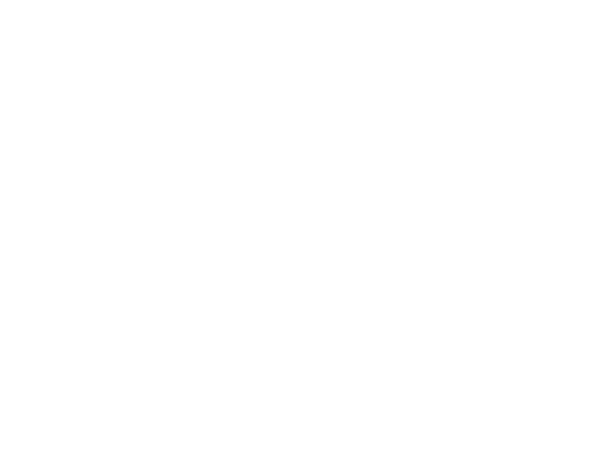

[[<Figure size 640x480 with 5 Axes>]]

In [1]:
from datetime import datetime
import backtrader as bt
import yfinance as yf

# Create a subclass of Strategy to define the indicators and logic

class SmaCross(bt.Strategy):
    # list of parameters which are configurable for the strategy
    params = dict(
        pfast=10,  # period for the fast moving average
        pslow=30   # period for the slow moving average
    )

    def __init__(self):
        sma1 = bt.ind.SMA(period=self.p.pfast)  # fast moving average
        sma2 = bt.ind.SMA(period=self.p.pslow)  # slow moving average
        self.crossover = bt.ind.CrossOver(sma1, sma2)  # crossover signal

    def next(self):
        if not self.position:  # not in the market
            if self.crossover > 0:  # if fast crosses slow to the upside
                self.buy()  # enter long

        elif self.crossover < 0:  # in the market & cross to the downside
            self.close()  # close long position


cerebro = bt.Cerebro()  # create a "Cerebro" engine instance

# Create a data feed
df = yf.download('AAPL',
             start=datetime(2011, 1, 1),
             end=datetime(2011, 12, 31)
                )

data = bt.feeds.PandasData(dataname=df) 

cerebro.adddata(data)  # Add the data feed
cerebro.addstrategy(SmaCross)  # Add the trading strategy
cerebro.broker.setcommission(commission= 0.2)

cerebro.run()  # run it all
cerebro.plot()  # and plot it with a single command

In [11]:
from datetime import datetime
import backtrader as bt
import yfinance as yf

class SmaCross(bt.Strategy):
    params = dict(
        pfast=10,  # period for the fast moving average
        pslow=30   # period for the slow moving average
    )

    def __init__(self):
        self.trade_history = []  # Список для хранения истории сделок
        sma1 = bt.ind.SMA(period=self.p.pfast)
        sma2 = bt.ind.SMA(period=self.p.pslow)
        self.crossover = bt.ind.CrossOver(sma1, sma2)

    def log(self, txt, dt=None):
        """ Logging function for this strategy"""
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt.isoformat()} - {txt}')

    def next(self):
        if not self.position:
            if self.crossover > 0:
                self.buy()
                self.log('BUY EXECUTED, Price: %.2f' % self.data.close[0])
                self.trade_history.append(('BUY', self.datas[0].datetime.date(0), self.data.close[0]))
        elif self.crossover < 0:
            self.close()
            self.log('SELL EXECUTED, Price: %.2f' % self.data.close[0])
            self.trade_history.append(('SELL', self.datas[0].datetime.date(0), self.data.close[0]))

    def stop(self):
        self.log('Ending Value: %.2f' % self.broker.getvalue())
        # Вывод истории сделок при завершении стратегии
        for trade in self.trade_history:
            print('Trade: %s on %s at price %.2f' % trade)

# Здесь продолжается ваш код для настройки и запуска Cerebro...



# Create a Cerebro entity
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(SmaCross)

# Create a data feed
df = yf.download('AAPL', start='2011-01-01', end='2011-12-31')
data = bt.feeds.PandasData(dataname=df)

cerebro.adddata(data)
cerebro.broker.set_cash(10000)
cerebro.broker.setcommission(commission=0.001)

print('Итог:', cerebro.broker.getvalue())
# Run the strategy
strategies = cerebro.run()
# cerebro.plot(block=False)

strategy = strategies[0]  # Получаем первый (и в данном случае единственный) экземпляр стратегии

# Теперь мы можем обратиться к trade_history этого экземпляра
trade_history = strategy.trade_history
for trade in trade_history:
    print('Trade: %s on %s at price %.2f' % trade)

[*********************100%%**********************]  1 of 1 completed

Итог: 10000
2011-04-27 - BUY EXECUTED, Price: 12.51
2011-05-20 - SELL EXECUTED, Price: 11.97
2011-07-05 - BUY EXECUTED, Price: 12.48
2011-08-16 - SELL EXECUTED, Price: 13.59
2011-09-06 - BUY EXECUTED, Price: 13.56
2011-10-06 - SELL EXECUTED, Price: 13.48
2011-10-17 - BUY EXECUTED, Price: 15.00
2011-11-14 - SELL EXECUTED, Price: 13.55
2011-12-12 - BUY EXECUTED, Price: 13.99
2011-12-30 - Ending Value: 9999.11
Trade: BUY on 2011-04-27 at price 12.51
Trade: SELL on 2011-05-20 at price 11.97
Trade: BUY on 2011-07-05 at price 12.48
Trade: SELL on 2011-08-16 at price 13.59
Trade: BUY on 2011-09-06 at price 13.56
Trade: SELL on 2011-10-06 at price 13.48
Trade: BUY on 2011-10-17 at price 15.00
Trade: SELL on 2011-11-14 at price 13.55
Trade: BUY on 2011-12-12 at price 13.99


# Пробую реализовать простую статегию на эфире

In [6]:
import matplotlib
matplotlib.use('Agg')  # Установка бэкенда перед импортом pyplot

import matplotlib.pyplot as plt
# import backtrader as bt

In [7]:
from binance.client import Client
import keys
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from tqdm import tqdm
# import mplfinance as mpf


pd.set_option('display.max_columns', None)

client = Client(keys.api_key, keys.api_secret)


def get_start_end_date():
    now = datetime.now()
    year_ago = now - timedelta(days=1300)


    date_start = year_ago.strftime('%d.%m.%Y')
    date_end = now.strftime('%d.%m.%Y')
    
    return date_start, date_end

date_start, date_end = get_start_end_date()

pair_names = "ETHUSDT"
load_list = client.get_historical_klines(pair_names, Client.KLINE_INTERVAL_1DAY, date_start, date_end)
df_quotes = pd.DataFrame(load_list, columns=['Open time',
 'Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'Close time',
 'Quote asset volume',
 'Number of trades',
 'Taker buy base asset volume',
 'Taker buy quote asset volume',
 'Ignore'])

# info = client.get_exchange_info()

In [8]:
# strategies[0]

In [9]:
def convert_formats(df):
    df = df.copy()    
    df['Open time'] = pd.to_datetime(df['Open time'], unit='ms')
    df['Close time'] = pd.to_datetime(df['Close time'], unit='ms')
    col_new_type = {'Open':float, 
                    'High':float, 
                    'Low':float,
                    'Close':float,
                    'Volume':float,
                    'Quote asset volume':float,
                    'Number of trades':int,
                    'Taker buy base asset volume':float,
                    'Taker buy quote asset volume':float
                   }
    
    df = df.astype(col_new_type)
    
    return df
df_main = convert_formats(df_quotes)
df_main = df_main.set_index('Close time')

In [24]:
from datetime import datetime
import backtrader as bt
import yfinance as yf

class SmaCross(bt.Strategy):
    params = dict(
        pfast=50,  # period for the fast moving average
        pslow=100   # period for the slow moving average
    )

    def __init__(self):
        self.trade_history = []  # Список для хранения истории сделок
        sma1 = bt.ind.SMA(period=self.p.pfast)
        sma2 = bt.ind.SMA(period=self.p.pslow)
        self.crossover = bt.ind.CrossOver(sma1, sma2)

    def log(self, txt, dt=None):
        """ Logging function for this strategy"""
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt.isoformat()} - {txt}')

    def next(self):
        if not self.position:
            if self.crossover > 0:
                self.buy()
                self.log('BUY EXECUTED, Price: %.2f' % self.data.close[0])
                self.trade_history.append(('BUY', self.datas[0].datetime.date(0), self.data.close[0]))
        elif self.crossover < 0:
            self.close()
            self.log('SELL EXECUTED, Price: %.2f' % self.data.close[0])
            self.trade_history.append(('SELL', self.datas[0].datetime.date(0), self.data.close[0]))

    def stop(self):
        self.log('Ending Value: %.2f' % self.broker.getvalue())
        # Вывод истории сделок при завершении стратегии
        for trade in self.trade_history:
            print('Trade: %s on %s at price %.2f' % trade)

class FractionalSizer(bt.Sizer):
    params = (('percents', 90), ('integer', False))

    def _getsizing(self, comminfo, cash, data, isbuy):
        """Returns a fractional size for a cash amount using a percentage of the total cash"""
        val = cash * (self.p.percents / 100)
        size = val / data.close[0]
        if not self.p.integer:
            return size
        else:
            return int(size)


            
            
# Здесь продолжается ваш код для настройки и запуска Cerebro...



# Create a Cerebro entity
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(SmaCross)

# Create a data feed
# df = yf.download('AAPL', start='2011-01-01', end='2011-12-31')
data = bt.feeds.PandasData(dataname=df_main)

cerebro.adddata(data)
cerebro.broker.set_cash(10000)
cerebro.broker.setcommission(commission=0.1)

# TODO https://www.backtrader.com/docu/sizers-reference/
cerebro.addsizer(bt.sizers.PercentSizer, percents=10) # Процент от капитала.
# Затем используйте этот sizer в вашем Cerebro
cerebro.addsizer(FractionalSizer)


print('Начало:', cerebro.broker.getvalue())
# Run the strategy
strategies = cerebro.run()
# cerebro.plot(block=False)

strategy = strategies[0]  # Получаем первый (и в данном случае единственный) экземпляр стратегии

# Теперь мы можем обратиться к trade_history этого экземпляра
trade_history = strategy.trade_history
for trade in trade_history:
    print('Trade: %s on %s at price %.2f' % trade)

Начало: 10000
2021-08-21 - BUY EXECUTED, Price: 3223.43
2022-04-13 - BUY EXECUTED, Price: 3118.28
2022-08-23 - BUY EXECUTED, Price: 1665.41
2023-01-26 - BUY EXECUTED, Price: 1601.09
2023-07-29 - BUY EXECUTED, Price: 1880.46
2023-11-10 - BUY EXECUTED, Price: 2077.72
2024-05-10 - Ending Value: 10000.00
Trade: BUY on 2021-08-21 at price 3223.43
Trade: BUY on 2022-04-13 at price 3118.28
Trade: BUY on 2022-08-23 at price 1665.41
Trade: BUY on 2023-01-26 at price 1601.09
Trade: BUY on 2023-07-29 at price 1880.46
Trade: BUY on 2023-11-10 at price 2077.72
Trade: BUY on 2021-08-21 at price 3223.43
Trade: BUY on 2022-04-13 at price 3118.28
Trade: BUY on 2022-08-23 at price 1665.41
Trade: BUY on 2023-01-26 at price 1601.09
Trade: BUY on 2023-07-29 at price 1880.46
Trade: BUY on 2023-11-10 at price 2077.72


In [25]:
with matplotlib.pyplot.ioff():
    figs = cerebro.plot(iplot=False)
    for fig in figs:
        for f in fig:
            plt.figure(f.number)  # Активируем фигуру для сохранения
            plt.savefig(f'my_strategy_plot{f.number}.png')
            plt.close(f)


In [12]:
plt.close('all')  # Закрывает все активные фигуры


In [13]:
strategies[0].broker.getvalue()

8793.058058888171

In [ ]:
Сейчая я думаю делать модель в этом же формате.
Все индикаторы которые будут влиять на шаге next я буду пробовать как-то выносить или 